In [53]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas


from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid


In [2]:
#gdf = GeoDataFrameDemos.districtRoyaleInNantesBuildings()
gdf = CirReader("C:/Users/zcui/Desktop/programming/Re_ Rnion bilan GLO dans le SIG/scene_masque.cir").run()

In [39]:
def segments(linestring):#transform linestring into segments
    seg_coords = list(zip(linestring.coords[:-1],linestring.coords[1:]))
    segment = []
    for i in range(len(seg_coords)):
        segment.append(LineString(seg_coords[i]))
    return segment

In [79]:
def NormalVector(vector1):#get the 2D normal vector of the building facets
    if vector1[1]==0:
        vector2 = np.array([0,1,vector1[2]])
    elif vector1[0]==0:
        vector2 = np.array([1,0,vector1[2]])
    else:
        vector2_y = -vector1[0]/vector1[1]
        vector2 = np.array([1,vector2_y,vector1[2]])
    return vector2

In [83]:
def VectorAngle(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    angle = np.arccos(dot_vector)
    return angle

In [84]:
def SunbeamVector(altitude_angle,azimuth_angle):#get the sunbeam vector depending on the altitude and azimuth angle
    vector_sun_x = sin(azimuth_angle)*cos(altitude_angle)
    vector_sun_y = cos(azimuth_angle)*cos(altitude_angle)
    vector_sun_z = sin(altitude_angle)
    vector_sun = np.array([vector_sun_x,vector_sun_y,vector_sun_z])
    return vector_sun

In [62]:
basemap_x=[]
basemap_y=[]
basemap_z=[]
sidewall_x=[]
sidewall_y=[]
sidewall_z=[]
for i in range(len(gdf)):
    f = gdf.geometry[i]
    fig = Polygon(f)
    x, y, z=zip(*fig.exterior.coords)
    #if sum(z)==0:
    
    if np.std(z)==0:
        basemap_x.append(x)
        basemap_y.append(y)
        basemap_z.append(z)
    else:
        sidewall_x.append(x)
        sidewall_y.append(y)
        sidewall_z.append(z)

In [19]:
elevation = []
for i in range(len(basemap_z)):
    elevation.append(np.mean(basemap_z[i]))
df = GeoDataFrame({'HAUTEUR':elevation},crs='epsg:2154')
df['gid'] = df.index+1

In [20]:
#lable
lable = []
for i in range(len(df)):
    if df.HAUTEUR[i]==0:
        lable.append("Ground")
    else:
        lable.append("Building")
df['Lable'] = lable

In [21]:
#geometry
#geometry
geometry =[]
for i in range(len(df)):
    p = Polygon(list(zip(basemap_x[i],basemap_y[i],basemap_z[i])))
    geometry.append(p)
df['geometry'] = geometry

_difference = df.geometry[0]#create ground with holes
for i in range(1,len(df)):
    _difference = _difference.difference(df.geometry[i])
df.at[0,'geometry']=_difference

In [22]:
#floor
floor = []
for i in range(len(df)):
    n=0
    if df.Lable[i] == 'Ground':
        floor.append(0)
    else:
        for j in range(len(sidewall_x)):
            q = Polygon(list(zip(sidewall_x[j],sidewall_y[j])))
            if df.geometry[i].contains(q):
                n = n+1
        nmb = len(basemap_x[i])-1
        floor.append(n/nmb)
df['floor'] = floor

In [23]:
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2

In [24]:
#sensors on the buildings
df2 = GeoDataFrame.copy(df)
df2.geometry = df.geometry.translate(355000,6689000)#I transfer the coordinate myself with constant value

df_buildings = GeoDataFrame.copy(df2)#Here I create a copy value of df for puting sensors
df_buildings.index -= 1
df_buildings.drop(df_buildings.index[df_buildings['Lable'] == 'Ground'], inplace = True)
sensors = STPointsDensifier2(df_buildings, curvAbsc=[0.5], pathidFieldname=None).run()
sensors.floor = sensors.floor.astype(int)

In [25]:
#create sensors in each floor level, input value 'sensors',output value 'sensors2'
from t4gpd.commons.GeomLib import GeomLib\

rows = []
for _,row in sensors.iterrows():
    for nfloor in range(row.floor):
        _row = row.copy()
        _row_z = nfloor*3.0+1.5
        _row.HAUTEUR = _row_z
        _row.floor = nfloor
        _row.geometry = GeomLib.forceZCoordinateToZ0(_row.geometry,_row_z)
        rows.append(_row)
sensors2 = GeoDataFrame(rows,crs=sensors.crs)
sensors2.reset_index(inplace=True,drop=True)

In [58]:
#create the segments of each building,output value 'seg'
line_x=[]
line_y=[]
line_z=[]
line = []
for i in range(len(df_buildings)):
    f = df_buildings.geometry[i]
    fig = Polygon(f)
    x, y, z=zip(*fig.exterior.coords)
    line_x.append(x)
    line_y.append(y)
    line_z.append(z)

for i in range(len(line_x)):
    line.append(LineString(list(zip(line_x[i],line_y[i]))))
    
seg = []
for i in range(len(line)):
    seg_part=list(segments(line[i]))
    for j in range(len(seg_part)):
        seg.append(seg_part[j])

In [82]:
#create the normal vector of wall
vector_wall=[]       
for i in range(len(seg)):
    seg_point1 = Point(seg[i].coords[0])
    seg_point2 = Point(seg[i].coords[1])
    vector_wall.append(np.array([seg_point1.x-seg_point2.x,seg_point1.y-seg_point2.y,0]))#here set z as 0 since they share the same roof level

normal_vector = []
for i in range(len(vector_wall)):
    normal_vector.append(NormalVector(vector_wall[i]))

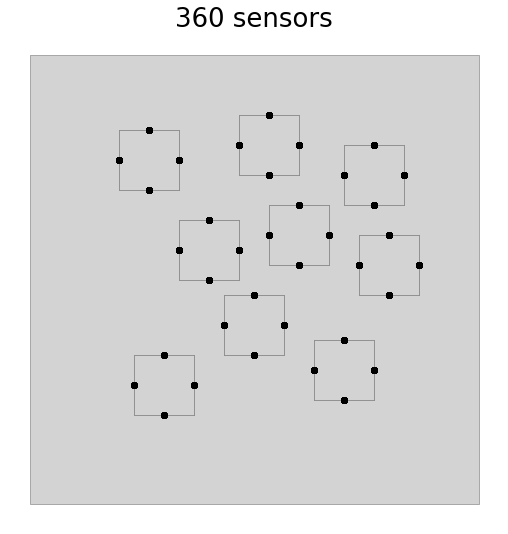

In [26]:
#plot top view(basemap with sensors)
fig, basemap = plt.subplots(figsize=(1.5 * 8.26, 1.1 * 8.26))
basemap.set_title(f'{len(sensors2)} sensors', size=26)
df2.plot(ax=basemap, color='lightgrey', edgecolor='dimgrey', linewidth=0.5)
sensors2.plot(ax=basemap, color='black')
basemap.axis('off')
plt.show()

In [27]:
#direct and diffuse irradiance of each sensor(using Perez method)
from t4gpd.energy.Perez import Perez
from pysolar.solar import *
from datetime import *
from t4gpd.commons.AngleLib import AngleLib

In [63]:
#value sun_hits means during the period how many times sun hit shine on the sensors
from t4gpd.sun.geoProcesses.SunshineDuration import SunshineDuration
from t4gpd.commons.DatetimeLib import DatetimeLib

latitude = 47.16
longitude = -1.60
delta = 0.16
epsilon = 6.3

dt = []
Direct = []
Diffuse = []
Alt_angle = []
for hour in range(14,15):
    for minutes in range(0,60,10):
        dt_s = datetime(2020,3,21,hour,minutes,tzinfo=timezone.utc)
        dt.append(dt_s)
        altitude_angle = get_altitude(latitude,longitude,dt_s)
        dayInYear = dt_s.timetuple().tm_yday
        direct = Perez.directSolarIrradiance(AngleLib.toRadians(altitude_angle),dayInYear,delta,epsilon)
        diffuse = Perez.diffuseSolarIrradiance(AngleLib.toRadians(altitude_angle),dayInYear,delta)
        Direct.append(direct)
        Diffuse.append(diffuse)
        Alt_angle.append(altitude_angle)
op = SunshineDuration(df_buildings,'HAUTEUR',dt)
sensors3 = STGeoProcess(op,sensors2).run()
sensors3

C:\Users\zcui\Miniconda3\envs\uenv\lib\site-packages\t4gpd\sun\geoProcesses\AbstractSunshineDuration.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  _angle = arctan(maskElevation / _dist)


,HAUTEUR,gid,Lable,geometry,floor,node_id,motion_dir,sun_hits,sun_ratio
0,1.5,2,Building,POINT Z (70.000 55.000 1.500),0,0#0#0,0.0#1.0,5,0.833333
1,4.5,2,Building,POINT Z (70.000 55.000 4.500),1,0#0#0,0.0#1.0,5,0.833333
2,7.5,2,Building,POINT Z (70.000 55.000 7.500),2,0#0#0,0.0#1.0,5,0.833333
3,10.5,2,Building,POINT Z (70.000 55.000 10.500),3,0#0#0,0.0#1.0,5,0.833333
4,13.5,2,Building,POINT Z (70.000 55.000 13.500),4,0#0#0,0.0#1.0,5,0.833333
...,...,...,...,...,...,...,...,...,...
1075,10.5,10,Building,POINT Z (40.000 40.000 10.500),3,8#0#11,-1.0#0.0,6,1.000000
1076,13.5,10,Building,POINT Z (40.000 40.000 13.500),4,8#0#11,-1.0#0.0,6,1.000000
1077,16.5,10,Building,POINT Z (40.000 40.000 16.500),5,8#0#11,-1.0#0.0,6,1.000000
1078,19.5,10,Building,POINT Z (40.000 40.000 19.500),6,8#0#11,-1.0#0.0,6,1.000000


In [64]:
#g_ir = sensors3.direct+diffuse#global horizontal radiation
import math
for i in range(len(Direct)): #set direct and diffuse value bigger than 0
    if Direct[i]<0:
        Direct[i]=0
    if Diffuse[i]<0:
        Diffuse[i]=0
Ave_Dir = sum(Direct)/len(Direct)
Ave_Dif = sum(Diffuse)/len(Diffuse)
Ave_Alt = AngleLib.toRadians(sum(Alt_angle)/len(Alt_angle))
Glo = Ave_Dif+sensors3.sun_ratio*Ave_Dir*math.cos(Ave_Alt)
sensors3['GlobalRadiation'] = Glo

In [29]:
#svf calculation
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor

op2 = SkyViewFactor(df_buildings,nRays=64,maxRayLen=100,
                  elevationFieldname= 'HAUTEUR',method=2018,background=True)
sensors4 = STGeoProcess(op2,sensors2).run()
print(sensors4)

SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
     HAUTEUR  gid     Lable                                 geometry  floor  \
0        1.5    2  Building   POINT Z (355070.000 6689060.000 1.500)      0   
1        4.5    2  Building   POINT Z (355070.000 6689060.000 4.500)      1   
2        7.5    2  Building   POINT Z (355070.000 6689060.000 7.500)      2   
3       10.5    2  Building  POINT Z (355070.000 6689060.000 10.500)      3   
4       13.5    2  Building  POINT Z (355070.000 6689060.000 13.500)      4   
..       ...  ...       ...                                      ...    ...   
355     10.5   10  Building  POINT Z (355045.000 6689040.000 10.500)      3   
356     13.5   10  Building  POINT Z (355045.000 6689040.000 13.500)      4   
357     16.5   10  Building  POINT Z (355045.000 6689040.000 16.500)      5   
358     19.5   10  Building  POINT Z (355045.000 6689040.000 19.500)      6   
359     22.5   10  Building  POINT Z (355045.000 66890

In [30]:
#plot sensors and buildings
buildings = df_buildings

roads = GeoDataFrame([
    {'gid': 1, 'geometry': LineString([[-30, -10], [30, -10]])},
    {'gid': 2, 'geometry': LineString([[-30, 10], [30, 10]])},
    {'gid': 3, 'geometry': LineString([[-20, -20], [-20, 20]])},
    {'gid': 4, 'geometry': LineString([[0, -20], [0, 20]])},
    {'gid': 5, 'geometry': LineString([[20, -20], [20, 20]])}
    ])

op = FootprintExtruder(buildings, 'HAUTEUR', forceZCoordToZero=True)
buildingsIn3d = STGeoProcess(op, buildings).run()

scene1 = ToUnstructuredGrid([buildingsIn3d,sensors4], 'svf').run()
#scene2 = ToUnstructuredGrid([buildingsIn3d,sensors2], 'floor').run()
#scene1 = ToUnstructuredGrid([buildingsIn3d, sensors2], 'HAUTEUR').run()

In [31]:
scene1.plot(scalars='svf', cmap='gist_earth', show_edges=False,
	show_scalar_bar=True, point_size=10.0, render_points_as_spheres=True)
#scene2.plot(scalars='floor', cmap='gist_earth', show_edges=False,
#	show_scalar_bar=True, point_size=5.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [16]:
gdf

,geometry
0,"POLYGON Z ((-30.000 -30.000 0.000, -30.000 120..."
1,"POLYGON Z ((100.000 60.000 0.000, 80.000 60.00..."
2,"POLYGON Z ((100.000 60.000 0.000, 100.000 40.0..."
3,"POLYGON Z ((80.000 60.000 0.000, 80.000 40.000..."
4,"POLYGON Z ((80.000 40.000 0.000, 80.000 40.000..."
...,...
365,"POLYGON Z ((100.000 60.000 30.000, 100.000 60...."
366,"POLYGON Z ((100.000 60.000 30.000, 100.000 40...."
367,"POLYGON Z ((80.000 60.000 30.000, 80.000 40.00..."
368,"POLYGON Z ((100.000 40.000 30.000, 80.000 40.0..."


In [17]:
ST_DumpSegments(gdf.geometry)

NameError: name 'ST_DumpSegments' is not defined